# importing necessary libraries.

In [2]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report


# obtaining the data.

In [3]:
warnings.filterwarnings('ignore')
df=pd.read_csv('clinvar_conflicting.csv')
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,NaN,not_specified,...,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,...,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,...,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


# data exploration.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  object 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

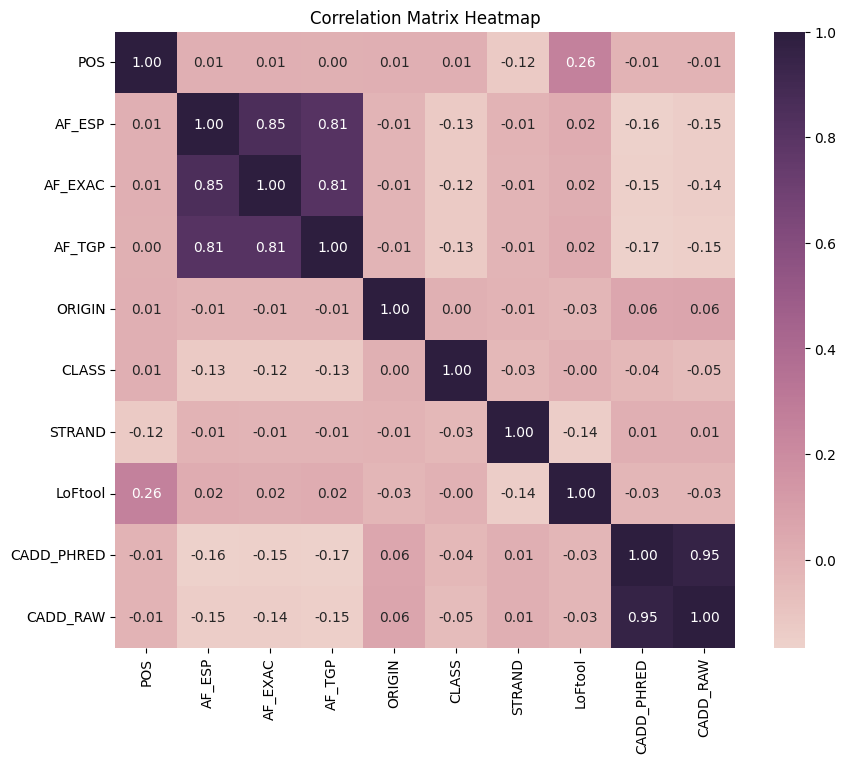

In [32]:
# filter numerical columns and create correlation heat matrix map
numerical_columns = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numerical_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,cmap=sns.cubehelix_palette(as_cmap=True), annot=True, fmt='.2f') 
plt.title('Correlation Matrix Heatmap')
plt.show()

In [6]:
display(df.corr(numeric_only=True).head())

,POS,AF_ESP,AF_EXAC,AF_TGP,ORIGIN,SSR,CLASS,DISTANCE,STRAND,MOTIF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
POS,1.000000,0.007003,0.007721,0.004225,0.013645,0.192398,0.012061,0.197942,-0.122896,NaN,-1.0,0.257226,-0.005409,-0.009753,0.022451
AF_ESP,0.007003,1.000000,0.851870,0.807741,-0.013563,-0.077253,-0.126538,0.295624,-0.011551,NaN,NaN,0.027343,-0.164169,-0.148118,0.039367
AF_EXAC,0.007721,0.851870,1.000000,0.805634,-0.013432,0.048413,-0.121213,0.291840,-0.013358,NaN,NaN,0.027831,-0.154891,-0.140803,0.038996
AF_TGP,0.004225,0.807741,0.805634,1.000000,-0.014450,-0.114526,-0.130077,0.040676,-0.014002,NaN,NaN,0.029447,-0.167057,-0.150989,0.043167
ORIGIN,0.013645,-0.013563,-0.013432,-0.014450,1.000000,0.175675,0.004357,NaN,-0.007564,NaN,NaN,-0.028363,0.060290,0.064609,-0.012681


# dropping the useless columns

In [7]:
df.drop(['CLNDISDBINCL','CLNDNINCL','CLNSIGINCL','CLNVI','SSR','INTRON','DISTANCE','BAM_EDIT','SIFT','PolyPhen','MOTIF_NAME','MOTIF_POS','HIGH_INF_POS','MOTIF_SCORE_CHANGE','BLOSUM62'],axis=1,inplace=True)

In [8]:
df.isnull().sum()

CHROM                   0
POS                     0
REF                     0
ALT                     0
AF_ESP                  0
AF_EXAC                 0
AF_TGP                  0
CLNDISDB                0
CLNDN                   0
CLNHGVS                 0
CLNVC                   0
MC                    846
ORIGIN                  0
CLASS                   0
Allele                  0
Consequence             0
IMPACT                  0
SYMBOL                 16
Feature_type           14
Feature                14
BIOTYPE                16
EXON                 8893
cDNA_position        8884
CDS_position         9955
Protein_position     9955
Amino_acids         10004
Codons              10004
STRAND                 14
LoFtool              4213
CADD_PHRED           1092
CADD_RAW             1092
dtype: int64

In [9]:
df['LoFtool'].fillna(int(df['LoFtool'].mean()), inplace=True)
df['CADD_PHRED'].fillna(int(df['CADD_PHRED'].mean()), inplace=True)
df['CADD_RAW'].fillna(int(df['CADD_RAW'].mean()), inplace=True)

In [10]:
df['STRAND'].fillna(df['STRAND'].mode()[0],inplace=True)

In [11]:
df['MC'].fillna(df['MC'].mode()[0],inplace=True)
df['SYMBOL'].fillna(df['SYMBOL'].mode()[0],inplace=True)
df['Feature_type'].fillna(df['Feature_type'].mode()[0],inplace=True)
df['Feature'].fillna(df['Feature'].mode()[0],inplace=True)
df['BIOTYPE'].fillna(df['BIOTYPE'].mode()[0],inplace=True)
df['EXON'].fillna(df['EXON'].mode()[0],inplace=True)
df['cDNA_position'].fillna(df['cDNA_position'].mode()[0],inplace=True)
df['CDS_position'].fillna(df['CDS_position'].mode()[0],inplace=True)
df['Protein_position'].fillna(df['Protein_position'].mode()[0],inplace=True)
df['Amino_acids'].fillna(df['Amino_acids'].mode()[0],inplace=True)
df['Codons'].fillna(df['Codons'].mode()[0],inplace=True)

In [12]:
df.isnull().sum()

CHROM               0
POS                 0
REF                 0
ALT                 0
AF_ESP              0
AF_EXAC             0
AF_TGP              0
CLNDISDB            0
CLNDN               0
CLNHGVS             0
CLNVC               0
MC                  0
ORIGIN              0
CLASS               0
Allele              0
Consequence         0
IMPACT              0
SYMBOL              0
Feature_type        0
Feature             0
BIOTYPE             0
EXON                0
cDNA_position       0
CDS_position        0
Protein_position    0
Amino_acids         0
Codons              0
STRAND              0
LoFtool             0
CADD_PHRED          0
CADD_RAW            0
dtype: int64

In [13]:
object_columns = df.select_dtypes(['object']).columns
object_columns
for c in df.columns:
    if c in object_columns:
        df[[c]]=df[[c]].astype('category')


In [14]:
cat_columns = df.select_dtypes(['category']).columns
print(cat_columns)
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
cat_columns

Index(['CHROM', 'REF', 'ALT', 'CLNDISDB', 'CLNDN', 'CLNHGVS', 'CLNVC', 'MC',
       'Allele', 'Consequence', 'IMPACT', 'SYMBOL', 'Feature_type', 'Feature',
       'BIOTYPE', 'EXON', 'cDNA_position', 'CDS_position', 'Protein_position',
       'Amino_acids', 'Codons'],
      dtype='object')


Index(['CHROM', 'REF', 'ALT', 'CLNDISDB', 'CLNDN', 'CLNHGVS', 'CLNVC', 'MC',
       'Allele', 'Consequence', 'IMPACT', 'SYMBOL', 'Feature_type', 'Feature',
       'BIOTYPE', 'EXON', 'cDNA_position', 'CDS_position', 'Protein_position',
       'Amino_acids', 'Codons'],
      dtype='object')

In [15]:
df.dtypes

CHROM                  int8
POS                   int64
REF                   int16
ALT                   int16
AF_ESP              float64
AF_EXAC             float64
AF_TGP              float64
CLNDISDB              int16
CLNDN                 int16
CLNHGVS               int32
CLNVC                  int8
MC                     int8
ORIGIN                int64
CLASS                 int64
Allele                int16
Consequence            int8
IMPACT                 int8
SYMBOL                int16
Feature_type           int8
Feature               int16
BIOTYPE                int8
EXON                  int16
cDNA_position         int16
CDS_position          int16
Protein_position      int16
Amino_acids           int16
Codons                int16
STRAND              float64
LoFtool             float64
CADD_PHRED          float64
CADD_RAW            float64
dtype: object

In [16]:
df.corr()['CLASS']

CHROM               0.002030
POS                 0.012061
REF                 0.000586
ALT                -0.000748
AF_ESP             -0.126538
AF_EXAC            -0.121213
AF_TGP             -0.130077
CLNDISDB            0.012407
CLNDN               0.023176
CLNHGVS            -0.013249
CLNVC               0.037792
MC                  0.006453
ORIGIN              0.004357
CLASS               1.000000
Allele              0.007442
Consequence        -0.001063
IMPACT              0.068912
SYMBOL              0.022337
Feature_type       -0.009541
Feature             0.001686
BIOTYPE             0.001276
EXON               -0.010719
cDNA_position       0.001162
CDS_position       -0.013194
Protein_position   -0.007400
Amino_acids        -0.016488
Codons             -0.004252
STRAND             -0.031551
LoFtool            -0.002226
CADD_PHRED         -0.037178
CADD_RAW           -0.052208
Name: CLASS, dtype: float64

# feature selection

In [17]:
original_df=df.copy()

In [18]:
# performing min max scaling so that we can get values in the range of 0 to 1 as chi square doesn't work on negative values
scaler=preprocessing.MinMaxScaler()
XScaled=scaler.fit_transform(df)
scaled_df=pd.DataFrame(XScaled,columns=df.columns)
scaled_df

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDN,CLNHGVS,...,EXON,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,STRAND,LoFtool,CADD_PHRED,CADD_RAW
0,0.378378,0.004714,0.505202,0.231947,0.154509,0.200444,0.213285,0.960251,0.967707,0.005001,...,0.000000,0.636839,0.608696,0.198283,0.203807,0.744930,1.0,0.00000,0.010626,0.101256
1,0.378378,0.005936,0.505202,0.000000,0.000000,0.000000,0.000000,0.716452,0.905929,0.007164,...,0.624272,0.606343,0.595813,0.188198,0.599524,0.515097,0.0,0.00000,0.313124,0.230528
2,0.378378,0.007015,0.000000,0.466083,0.000000,0.000020,0.000000,0.081230,0.912518,0.018086,...,0.814281,0.713222,0.292637,0.928591,0.380650,0.366381,0.0,0.00000,0.283831,0.221763
3,0.378378,0.008721,0.505202,0.000000,0.000000,0.000000,0.000000,0.649085,0.880873,0.028012,...,0.016243,0.115685,0.000293,0.624012,0.298969,0.235692,1.0,0.00000,0.227265,0.165122
4,0.378378,0.008721,0.505202,0.733042,0.000000,0.000000,0.000000,0.648652,0.880657,0.028027,...,0.016243,0.115685,0.000293,0.624012,0.287074,0.236593,1.0,0.00000,0.249487,0.196865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65183,1.000000,0.622588,0.744509,0.466083,0.160521,0.278521,0.321128,0.346041,0.422832,0.983171,...,0.132087,0.483428,0.467940,0.077133,0.767645,0.938711,0.0,0.00158,0.001051,0.093141
65184,1.000000,0.622592,0.258960,0.733042,0.004008,0.001200,0.002601,0.967400,0.981207,0.983218,...,0.132087,0.382490,0.365613,0.993322,0.915147,0.241100,0.0,0.00158,0.000010,0.071990
65185,1.000000,0.622737,0.258960,0.733042,0.025050,0.007402,0.022209,0.967400,0.981207,0.983264,...,0.935642,0.097287,0.048016,0.671573,0.061856,0.789995,0.0,0.00158,0.129789,0.132411
65186,1.000000,0.623929,0.744509,0.231947,0.000601,0.000680,0.000000,0.890393,0.721784,0.983279,...,0.254980,0.869998,0.631313,0.219815,0.848533,0.398828,0.0,0.00000,0.001303,0.093881


In [19]:
# using chi square for feature selection
data=scaled_df.copy()
X = data.loc[:,data.columns!='CLASS']
y = data.loc[:,'CLASS']
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(8,'Score'))#printing the 8 best features

         Specs       Score
6       AF_TGP  512.323040
4       AF_ESP  481.512304
5      AF_EXAC  468.705551
15      IMPACT   35.646297
26      STRAND   32.669229
28  CADD_PHRED    6.705156
16      SYMBOL    6.215260
8        CLNDN    5.866560


In [20]:
X = data[featureScores.sort_values(by='Score', ascending=False).iloc[:8,0]]
y = data['CLASS']
X

,AF_TGP,AF_ESP,AF_EXAC,IMPACT,STRAND,CADD_PHRED,SYMBOL,CLNDN
0,0.213285,0.154509,0.200444,0.666667,1.0,0.010626,0.085948,0.967707
1,0.000000,0.000000,0.000000,0.666667,0.0,0.313124,0.917490,0.905929
2,0.000000,0.000000,0.000020,0.666667,0.0,0.283831,0.383326,0.912518
3,0.000000,0.000000,0.000000,0.666667,1.0,0.227265,0.811775,0.880873
4,0.000000,0.000000,0.000000,0.666667,1.0,0.249487,0.811775,0.880657
...,...,...,...,...,...,...,...,...
65183,0.321128,0.160521,0.278521,0.333333,0.0,0.001051,0.303825,0.422832
65184,0.002601,0.004008,0.001200,0.666667,0.0,0.000010,0.303825,0.981207
65185,0.022209,0.025050,0.007402,0.333333,0.0,0.129789,0.303825,0.981207
65186,0.000000,0.000601,0.000680,0.333333,0.0,0.001303,0.735281,0.721784


In [21]:
accsLogistic = []
skf = StratifiedKFold(n_splits=10,random_state=1, shuffle=True)

# prediciton using Logistic Regression Model

In [22]:
for train_index, test_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]
    LRModel = LogisticRegression(penalty = 'l2',max_iter=500)
    LRModel.fit(X_train, y_train)
    Y_testPred = LRModel.predict(X_test)
    testAccuracy = accuracy_score(y_test, Y_testPred)
    print("Test Accuracy", testAccuracy*100)
    accsLogistic.append(testAccuracy*100)
print("accuracies in iterations : ",accsLogistic)
print("AVG: ",sum(accsLogistic)/len(accsLogistic))

Test Accuracy 74.79674796747967
Test Accuracy 74.79674796747967
Test Accuracy 74.79674796747967
Test Accuracy 74.79674796747967
Test Accuracy 74.7814081914404
Test Accuracy 74.7814081914404
Test Accuracy 74.7814081914404
Test Accuracy 74.7814081914404
Test Accuracy 74.79288125191776
Test Accuracy 74.79288125191776
accuracies in iterations :  [74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.7814081914404, 74.7814081914404, 74.7814081914404, 74.7814081914404, 74.79288125191776, 74.79288125191776]
AVG:  74.78983871395158


# prediction using Decision Tree Classifier

In [23]:
accsDecisionTreeClasifier = []

In [24]:
# using Decision Tree Classifier
dtree = DecisionTreeClassifier()
for train_index, test_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]
    dtree.fit(X_train, y_train)
    Y_testPred = dtree.predict(X_test)
    testAccuracy = accuracy_score(y_test, Y_testPred)
    print("Test Accuracy", testAccuracy*100)
    accsDecisionTreeClasifier.append(testAccuracy*100)
print("accuracies in iterations : ",accsDecisionTreeClasifier)
print("AVG: ",sum(accsDecisionTreeClasifier)/len(accsDecisionTreeClasifier))

Test Accuracy 72.29636447307868
Test Accuracy 73.07869305108146
Test Accuracy 71.97422917625403
Test Accuracy 71.0691823899371
Test Accuracy 72.02024850437184
Test Accuracy 73.06335327504219
Test Accuracy 71.69811320754717
Test Accuracy 72.541800889707
Test Accuracy 72.52224608775698
Test Accuracy 72.61429886468241
accuracies in iterations :  [72.29636447307868, 73.07869305108146, 71.97422917625403, 71.0691823899371, 72.02024850437184, 73.06335327504219, 71.69811320754717, 72.541800889707, 72.52224608775698, 72.61429886468241]
AVG:  72.28785299194588


# prediction using Naive Bayes Classifier

In [25]:
accsNaiveBayesClassifier = []

In [26]:
# as Naive Bayes is giving very low accuracy for min max scaled data
X =original_df[featureScores.sort_values(by='Score', ascending=False).iloc[:8,0]]
y = original_df['CLASS']
X

,AF_TGP,AF_ESP,AF_EXAC,IMPACT,STRAND,CADD_PHRED,SYMBOL,CLNDN
0,0.1066,0.0771,0.10020,2,1.0,1.053,200,8960
1,0.0000,0.0000,0.00000,2,-1.0,31.000,2135,8388
2,0.0000,0.0000,0.00001,2,-1.0,28.100,892,8449
3,0.0000,0.0000,0.00000,2,1.0,22.500,1889,8156
4,0.0000,0.0000,0.00000,2,1.0,24.700,1889,8154
...,...,...,...,...,...,...,...,...
65183,0.1605,0.0801,0.13923,1,-1.0,0.105,707,3915
65184,0.0013,0.0020,0.00060,2,-1.0,0.002,707,9085
65185,0.0111,0.0125,0.00370,1,-1.0,12.850,707,9085
65186,0.0000,0.0003,0.00034,1,-1.0,0.130,1711,6683


In [27]:
# using Naive Bayes Classifier

gnb = GaussianNB()
for train_index, test_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]
    gnb.fit(X_train, y_train)
    Y_testPred = gnb.predict(X_test)
    testAccuracy = accuracy_score(y_test, Y_testPred)
    print("Test Accuracy", testAccuracy*100)
    accsNaiveBayesClassifier.append(testAccuracy*100)
print("accuracies in iterations : ",accsNaiveBayesClassifier)
print("AVG: ",sum(accsNaiveBayesClassifier)/len(accsNaiveBayesClassifier))

Test Accuracy 72.89461573861021
Test Accuracy 72.89461573861021
Test Accuracy 72.97131461880657
Test Accuracy 73.07869305108146
Test Accuracy 73.21675103543488
Test Accuracy 72.83325663445314
Test Accuracy 72.74121797821752
Test Accuracy 73.37014879582759
Test Accuracy 73.27401043264805
Test Accuracy 73.64222154034981
accuracies in iterations :  [72.89461573861021, 72.89461573861021, 72.97131461880657, 73.07869305108146, 73.21675103543488, 72.83325663445314, 72.74121797821752, 73.37014879582759, 73.27401043264805, 73.64222154034981]
AVG:  73.09168455640395


# K NEAREST NEIGHBOUR

In [28]:
from sklearn.neighbors import KNeighborsClassifier
import math
accsKneighbour=[]
for train_index, test_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]
    KNNModel = KNeighborsClassifier(n_neighbors=int(math.sqrt(train_index.shape[0])))
    KNNModel.fit(X_train, y_train)
    Y_testPred = KNNModel.predict(X_test)
    testAccuracy = accuracy_score(y_test, Y_testPred)
    print("Test Accuracy", testAccuracy*100)
    accsKneighbour.append(testAccuracy*100)
print(accsKneighbour)
print("AVG: ",sum(accsKneighbour)/len(accsKneighbour))

Test Accuracy 74.96548550391165
Test Accuracy 74.68936953520479
Test Accuracy 74.62801043104771
Test Accuracy 74.87344684767604
Test Accuracy 74.75072863936187
Test Accuracy 74.75072863936187
Test Accuracy 74.7814081914404
Test Accuracy 74.87344684767604
Test Accuracy 75.00767106474379
Test Accuracy 74.85424976986805
[74.96548550391165, 74.68936953520479, 74.62801043104771, 74.87344684767604, 74.75072863936187, 74.75072863936187, 74.7814081914404, 74.87344684767604, 75.00767106474379, 74.85424976986805]
AVG:  74.81745454702921


# f-1 score , recall and precision values

In [29]:
report  = classification_report(y_test,Y_testPred,output_dict = True)
report

{'0': {'precision': 0.7513202858030444,
  'recall': 0.9922051282051282,
  'f1-score': 0.8551224255281534,
  'support': 4875.0},
 '1': {'precision': 0.525,
  'recall': 0.02556299452221546,
  'f1-score': 0.04875217643644806,
  'support': 1643.0},
 'accuracy': 0.7485424976986805,
 'macro avg': {'precision': 0.6381601429015222,
  'recall': 0.5088840613636718,
  'f1-score': 0.4519373009823007,
  'support': 6518.0},
 'weighted avg': {'precision': 0.694271462609672,
  'recall': 0.7485424976986805,
  'f1-score': 0.6518597192904008,
  'support': 6518.0}}

In [30]:
# Initialize lists to store metrics for each iteration
f1_scores = []
precisions = []
recalls = []

for train_index, test_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]
    LRModel = LogisticRegression(penalty = 'l2',max_iter=500)
    LRModel.fit(X_train, y_train)
    Y_testPred = LRModel.predict(X_test)
    testAccuracy = accuracy_score(y_test, Y_testPred)
    print("Test Accuracy", testAccuracy*100)
    
    # Append metrics to respective lists
    f1_scores.append(report['macro avg']['f1-score'])
    precisions.append(report['macro avg']['precision'])
    recalls.append(report['macro avg']['recall'])
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, Y_testPred))
    accsLogistic.append(testAccuracy*100)
    
print("accuracies in iterations : ",accsLogistic)
print("AVG: ",sum(accsLogistic)/len(accsLogistic))
# f1 score
print("F1 Scores in iterations:", f1_scores)
avg_f1_score = np.mean(f1_scores)
print("Average F1 Score:", avg_f1_score)

# precision
print("Precisions in iterations:", precisions)
avg_precision = np.mean(precisions)
print("Average Precision:", avg_precision)

# recall
print("Recalls in iterations:", recalls)
avg_recall = np.mean(recalls)
print("Average Recall:", avg_recall)


Test Accuracy 74.79674796747967
Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      4876
           1       0.00      0.00      0.00      1643

    accuracy                           0.75      6519
   macro avg       0.37      0.50      0.43      6519
weighted avg       0.56      0.75      0.64      6519

Test Accuracy 74.79674796747967
Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      4876
           1       0.00      0.00      0.00      1643

    accuracy                           0.75      6519
   macro avg       0.37      0.50      0.43      6519
weighted avg       0.56      0.75      0.64      6519

Test Accuracy 74.79674796747967
Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      4876
           1       0.00      0.00      0.00      1643

    accuracy     